# Vaccines applications Espirito Santo - BR

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import date
from ipynb.fs.full.functions import took_shot
from ipynb.fs.full.functions import convert_to_datetime

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Reading data

In [9]:
dados_raw = pd.concat([pd.read_csv("vacina_es1.csv", sep = ";"), pd.read_csv("vacina_es2.csv", sep = ";")], ignore_index = True)

c:\Users\Matheus\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
ibge = pd.read_excel('atlas2013.xlsx', 'MUN 91-00-10')[['ANO', 'Codmun6', 'GINI', 'IDHM_E', 'IDHM_L', 'IDHM_R']]

In [ ]:
ibge = ibge[ibge['ANO'] == 2010].drop('ANO', axis=1)

In [ ]:
ibge.columns = ['paciente_endereco_coIbgeMunicipio', 'GINI', 'IDHM_E', 'IDHM_L', 'IDHM_R']

In [ ]:
dados_raw['paciente_endereco_coIbgeMunicipio'] = pd.to_numeric(dados_raw['paciente_endereco_coIbgeMunicipio'], errors='coerce')

In [11]:
dados_raw = dados_raw[['paciente_id', 'paciente_idade','paciente_enumSexoBiologico','paciente_racaCor_valor',
       'paciente_endereco_coIbgeMunicipio','vacina_grupoAtendimento_nome', 'vacina_fabricante_nome',
       'vacina_dataAplicacao','vacina_descricao_dose']]

In [ ]:
dados_raw=pd.merge(dados_raw, ibge, on='paciente_endereco_coIbgeMunicipio', how='left')

In [ ]:
dados_raw.head()

,paciente_id,paciente_idade,paciente_enumSexoBiologico,paciente_racaCor_valor,paciente_endereco_coIbgeMunicipio,vacina_grupoAtendimento_nome,vacina_fabricante_nome,vacina_dataAplicacao,vacina_descricao_dose
0,0a786f8bf05d7784dcd7d1ae4517db63731b887c6c9c92...,63.0,M,SEM INFORMACAO,320390,Pessoas de 18 a 64 anos,JANSSEN,2022-05-09,Reforço
1,fdd45c0e79fc84ee7e82e7bfb0b5905eac31f5389e1bca...,56.0,M,PARDA,320500,Pessoas de 18 a 64 anos,SINOVAC/BUTANTAN,2021-11-20,1ª Dose
2,abffe68f6bc2086d122a9a106e2d2472abea16a15204e3...,69.0,F,BRANCA,320030,Pessoas de 65 a 69 anos,PFIZER,2021-11-22,Reforço
3,1570c731e4312b47514e935e178d2e3bb782c96c16c298...,48.0,M,SEM INFORMACAO,320130,Outros,SINOVAC/BUTANTAN,2021-03-30,1ª Dose
4,9b500e2f18625b82ac4b08e3f5efc7a5e99c7370fee915...,57.0,M,SEM INFORMACAO,314330,Pessoas de 18 a 64 anos,PFIZER,2022-01-06,Reforço


In [12]:
dados_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5666150 entries, 0 to 5666149
Data columns (total 9 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   paciente_id                        object 
 1   paciente_idade                     float64
 2   paciente_enumSexoBiologico         object 
 3   paciente_racaCor_valor             object 
 4   paciente_endereco_coIbgeMunicipio  object 
 5   vacina_grupoAtendimento_nome       object 
 6   vacina_fabricante_nome             object 
 7   vacina_dataAplicacao               object 
 8   vacina_descricao_dose              object 
dtypes: float64(1), object(8)
memory usage: 389.1+ MB


## Filtering

Excluding NAs

In [13]:
dados_raw.isnull().sum()

paciente_id                              2
paciente_idade                           2
paciente_enumSexoBiologico               2
paciente_racaCor_valor                   2
paciente_endereco_coIbgeMunicipio    19802
vacina_grupoAtendimento_nome            16
vacina_fabricante_nome                   0
vacina_dataAplicacao                     0
vacina_descricao_dose                    0
dtype: int64

In [14]:
dados_raw = dados_raw.dropna()

Filtering age and other outliers

In [15]:
dados_raw = dados_raw.loc[(dados_raw["paciente_idade"] <= 90) & (dados_raw["paciente_idade"] >= 18)]

In [16]:
dados_raw = dados_raw[dados_raw['paciente_enumSexoBiologico'] != 'I']

<AxesSubplot:xlabel='paciente_idade'>

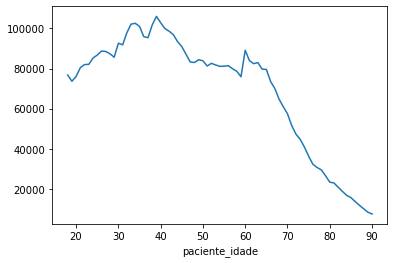

In [17]:
dados_raw.groupby("paciente_idade")["paciente_idade"].count().plot()

In [18]:
dados_raw = dados_raw[dados_raw["paciente_racaCor_valor"] != 'SEM INFORMACAO']

The info below looks wrong, once the person age doesn't fit the vaccination group registered

In [19]:
dados_raw = dados_raw[dados_raw["vacina_grupoAtendimento_nome"] != 'Pessoas de 12 a 17 anos']

Vaccination groups are being groupped in more general groups. Commorbities, risk professions, regular people and others.

In [20]:
regular = ['Pessoas de 18 a 64 anos', 'Pessoas de 65 a 69 anos']
comorbidades = ['Doenças Cardiovasculares e Cerebrovasculares','Pessoas de 75 a 79 anos',
'Hipertensão de difícil controle ou com complicações/lesão de órgão alvo','Pessoas de 80 anos ou mais',
'Diabetes Mellitus', 'Obesidade Grave (Imc≥40)', 'Pessoas de 70 a 74 anos','Outros Imunocomprometidos',
'Gestante', 'Doença Renal Crônica', 'Síndrome de Down', 'Pneumopatias Crônicas Graves', 'Pessoas com Deficiência Permanente',
'Doença cardiovascular', 'Hemoglobinopatia grave', 'Doença neurológica crônica', 'Pessoas com Deficiência Institucionalizadas',
'Neoplasias', 'Indivíduos Transplantados de Órgão Sólido', 'Cirrose hepática', 'Indivíduos Transplantados de Medula Óssea']
profissao = ['Ensino Básico', 'Quilombola', 'Trabalhadores Portuários', 'Recepcionista', 'Farmacêutico',
'Médico', 'Ensino Superior','Auxiliar de Enfermagem', 'Assistente Social', 'Bombeiro Militar', 'Técnico de Enfermagem',
'Acadêmicos/estudantes em estágio em estabelecimentos de saúde', 'Profissionais e Auxiliares de limpeza','Motorista de Ambulância',
'Odontologista', 'Coletivo Rodoviário Passageiros Urbano e de Longo Curso', 'Puérpera', 'Funcionário do Sistema de Privação de Liberdade',
'Cozinheiro e Auxiliares', 'Pessoas de 60 nos ou mais Institucionalizadas', 'Fisioterapeutas', 'Policial Militar',
'Funcionário do Sistema Funerário que tenham contato com cadáveres potencialmente contaminados', 'Guarda Municipal',
'Pessoas em Situação de Rua', 'Policial Civil', 'Nutricionista', 'Cuidador de Idosos', 'Povos indígenas em terras indígenas',
'Técnico de Odontologia', 'Enfermeiro(a)', 'Fonoaudiólogo', 'Psicólogo', 'Profissionais de Educação Física',
'Médico Veterinário', 'Segurança', 'Biólogo', 'Policial Federal', 'Biomédico', 'Aéreo', 'Policial Rodoviário Federal',
'Auxiliar de Veterinário', 'Bombeiro Civil', 'Terapeuta Ocupacional', 'Auxiliar em Saúde Bucal - ASB', 'Marinha do Brasil - MB',
'Caminhoneiro', 'População Privada de Liberdade', 'Ferroviário', 'Exército Brasileiro - EB', 'Técnico de Veterinário',
'Técnico em Saúde Bucal - TSB', 'Agente Comunitário de Saúde - ACS', 'Trabalhadores Industriais', 'Agente de Combate a Endemias - ACE',
'Doula/Parteira', 'Trabalhadores de limpeza urbana e manejo de resíduos sólidos', 'Aquaviário', 'Força Aérea Brasileira - FAB',
'Metroviário', 'Ribeirinha']
outros = ['Outros', "Outros Grupos", 'Pessoas de 5 a 11 anos', 'Sem registro no modelo de informação de origem']

In [21]:
dados_raw["vacina_grupoAtendimento_nome"] = dados_raw["vacina_grupoAtendimento_nome"].replace(regular, "Regular")
dados_raw["vacina_grupoAtendimento_nome"] = dados_raw["vacina_grupoAtendimento_nome"].replace(comorbidades, "Comorbidades")
dados_raw["vacina_grupoAtendimento_nome"] = dados_raw["vacina_grupoAtendimento_nome"].replace(profissao, "Profissao/Situacao de Risco")
dados_raw["vacina_grupoAtendimento_nome"] = dados_raw["vacina_grupoAtendimento_nome"].replace(outros, "Outros")

Vaccines applied are also being groupped in more general groups. The important here is to separate those vaccines whose intervals between doses differ from each other.

In [22]:
dados_raw["vacina_fabricante_nome"] = dados_raw["vacina_fabricante_nome"].replace('ASTRAZENECA/FIOCRUZ', 'ASTRAZENECA')
dados_raw["vacina_fabricante_nome"] = dados_raw["vacina_fabricante_nome"].replace('SINOVAC/BUTANTAN', 'CORONAVAC')
dados_raw = dados_raw[dados_raw["vacina_fabricante_nome"].isin(["PFIZER", "CORONAVAC", "ASTRAZENECA", "JANSSEN"])]

In [23]:
dados_raw["vacina_descricao_dose"].unique()

array(['1ª Dose', 'Reforço', '2ª Dose', 'Dose', '4ª Dose',
       'Dose Adicional', 'Única', '3ª Dose'], dtype=object)

In [24]:
dados_raw = dados_raw[dados_raw["vacina_descricao_dose"].isin(['1ª Dose', '2ª Dose'])]

We've already tidied most of the features we're using in our final dataset. Now we need to separate 1st and 2nd doses in different columns so we can compare the applications dates.

In [26]:
dados_1dose = dados_raw[dados_raw["vacina_descricao_dose"] == '1ª Dose'].reset_index(drop=True)
dados_1dose['dose1'] = dados_1dose['vacina_dataAplicacao']
dados_1dose = dados_1dose.drop(['vacina_dataAplicacao', 'vacina_descricao_dose'], axis = 1)

dados_2dose = dados_raw[dados_raw["vacina_descricao_dose"] == '2ª Dose'][['paciente_id', 'vacina_dataAplicacao']].reset_index(drop=True)
dados_2dose.columns = ['paciente_id', 'dose2']


In [27]:
dados_merge = pd.merge(dados_1dose, dados_2dose, how='left', on='paciente_id')

In [28]:
dados_merge['dose1'] = dados_merge['dose1'].apply(lambda x: convert_to_datetime(x))
dados_merge['dose2'] = dados_merge['dose2'].apply(lambda x: convert_to_datetime(x))

In [29]:
dados_merge['took_2nd'] = took_shot(dados_merge['dose1'], dados_merge['dose2'], dados_merge['vacina_fabricante_nome'])

In [30]:
dados = dados_merge[dados_merge['took_2nd'] != 2].drop(['paciente_id', 'paciente_endereco_coIbgeMunicipio', 'dose1', 'dose2'], axis=1)

In [31]:
dados_dummy = pd.get_dummies(dados[['paciente_enumSexoBiologico', 'paciente_racaCor_valor', 'vacina_grupoAtendimento_nome',
'vacina_fabricante_nome']], drop_first = True)

In [32]:
x = pd.merge(dados[['paciente_idade', 'GINI', 'IDHM_E', 'IDHM_L', 'IDHM_R']], dados_dummy, left_index=True, right_index=True)
y = dados['took_2nd']

In [33]:
x.head()

,paciente_idade,paciente_enumSexoBiologico_M,paciente_racaCor_valor_BRANCA,paciente_racaCor_valor_INDIGENA,paciente_racaCor_valor_PARDA,paciente_racaCor_valor_PRETA,vacina_grupoAtendimento_nome_Outros,vacina_grupoAtendimento_nome_Profissao/Situacao de Risco,vacina_grupoAtendimento_nome_Regular,vacina_fabricante_nome_CORONAVAC,vacina_fabricante_nome_JANSSEN,vacina_fabricante_nome_PFIZER
0,56.0,1,0,0,1,0,0,0,1,1,0,0
1,40.0,0,1,0,0,0,0,0,1,0,0,1
2,40.0,0,1,0,0,0,0,0,1,0,0,1
3,36.0,1,1,0,0,0,0,0,1,1,0,0
4,36.0,1,1,0,0,0,0,0,1,1,0,0


In [34]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [35]:
clf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [36]:
clf.score(X_test, y_test)

0.5433527619384775

In [38]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)


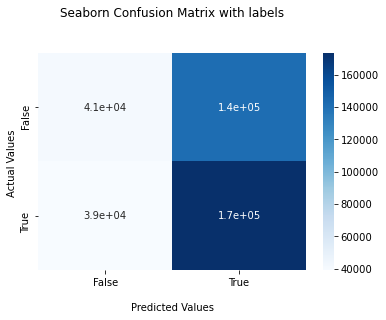

In [40]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Did not take','Took 2nd'])
ax.yaxis.set_ticklabels(['Did not take','Took 2nd'])

plt.show()